# 🧮  A Simple & Interactive Coding Introduction to Conformal Prediction  🧮


© Fai Khalif 2025

# Understanding the Problem 🤔

The first step in building a conformal prediction algorithm/framework and applying conformal prediction is understanding the problem at hand and whether or not it is a **good candidate problem** for the application of conformal prediction.
🤔



#What is Conformal Prediction? When Should I Use It? 💭

Conformal Prediction:

* is a method that allows to make predictions with a **guaranteed level of confidence**.
* allows us to engage in **uncertainty quantification** without prior knowledge of the distribution of a data set.
* is particularly useful in **multiclass** classification context, especially in **high risk decision making contexts**, when you are okay with reporting prediction sets with more than one output at times but want to **guarantee coverage** of the correct answer at a high rate (guaranteed level of confidence).

For example, you are working on a diagnostic algorithm and want to make sure that the exact patient diagnosis is, at a confidence level of 95%, going to be in the prediction set. you can even increase the confidence level to 99%. The posibilites are endless.


You can use conformal prediction in binary classification contexts, but its then possible that the framework won't produce much more information for you than expected because, in order to meet the high confidence level you set, the model may just routinely increase the prediction set size to include both posibilities. (Whereas in a multiclass context, if we can exclude even one possibility at least we are now highly confident that we don't have to worry about that option).



#A Great Resource

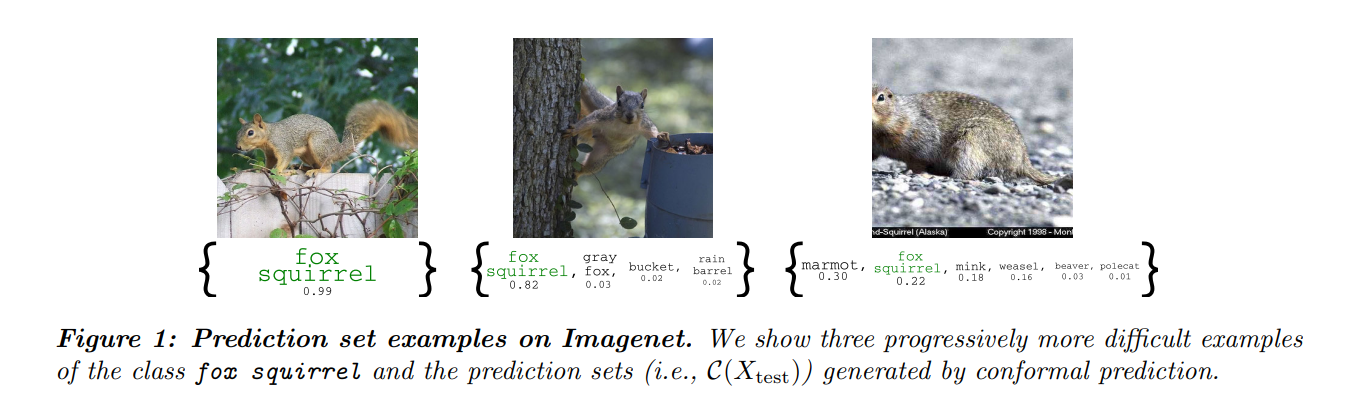

The example above is a nice visual example of conformal prediction from this source: https://arxiv.org/pdf/2107.07511

It's really beautiful and well written. 10/10 recommend!

#Base Model
The second step in developing a conformal prediction algorithm is developing your Base Model. You want to build the best, most accurate base model possible for your predictive problem.

For the easy code tutorial example, we use a simple nlp dataset to classify the tone of a sentence.

Here's a kaggle link to the data: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp?select=test.txt

In [ ]:
#Importing Everything
import pandas as pd
import numpy as np
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# === Step 1: Load dataset ===
def load_dataset(filepath):
    df = pd.read_csv(filepath, sep=';', names=['text', 'label'], engine='python')
    return df

train_df = load_dataset('train.txt')
val_df = load_dataset('val.txt')
test_df = load_dataset('test.txt')

# === Step 2: Preprocess text ===
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]  # remove stopwords
    return ' '.join(tokens)

train_df['text'] = train_df['text'].apply(clean_text)
val_df['text'] = val_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

# === Step 3: Encode labels ===
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])
val_df['label'] = le.transform(val_df['label'])
test_df['label'] = le.transform(test_df['label'])
calib_X = val_df['text']
calib_Y = val_df['label']

# === Step 4: Train TF-IDF + XGBoost pipeline ===
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

pipeline = Pipeline([
    ('tfidf', vectorizer),
    ('clf', clf)
])

# Optionally: Grid search
# params = {
#     'clf__max_depth': [3, 5],
#     'clf__n_estimators': [100, 200],
# }
# grid = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='accuracy')
# grid.fit(train_df['text'], train_df['label'])
# best_model = grid.best_estimator_

# Train basic model
pipeline.fit(train_df['text'], train_df['label'])

# === Step 5: Evaluate ===
test_preds = pipeline.predict(test_df['text'])
print(classification_report(test_df['label'], test_preds, target_names=le.classes_))

              precision    recall  f1-score   support

       anger       0.91      0.88      0.89       274
        fear       0.89      0.89      0.89       224
         joy       0.89      0.91      0.90       695
        love       0.74      0.82      0.78       159
     sadness       0.96      0.91      0.93       581
    surprise       0.64      0.68      0.66        66

    accuracy                           0.89      1999
   macro avg       0.84      0.85      0.84      1999
weighted avg       0.89      0.89      0.89      1999



#Conformal Prediction

Finally: The actual uncertainty quantification and application.

First, we get the conformal scores from our calibration set, in order to then get the probability assigned to the true class.

Then we calculate the quantile for our conformal threshold (and you can set alpha to whatever level of uncertainty you prefer/is best for your given problem).

Then, to build our final output/prediction set for each input, we take the largest confidence/ highest probability* prediction and add it to our prediction set, until the total confidence of the set is equal to or greater than our stated level of confidence.

[ex: if we want to be at least 95% confident, we have to keep adding predictions until the total prediction set has a coverage of 95% certain or higher]

*calculated from our calibration set

In [ ]:
# === Step 1: Get conformal scores from calibration set ===
calib_probs = pipeline.predict_proba(calib_X)  # shape (n_samples, n_classes)
n = len(calib_Y)

# The probability assigned to the true class
cal_scores = 1 - calib_probs[np.arange(n), calib_Y]

# === Step 2: Compute quantile for conformal threshold ===
alpha = 0.05  # 95% coverage, adjust as needed
q_level = np.ceil((n + 1) * (1 - alpha)) / n
qhat = np.quantile(cal_scores, q_level, method='higher')

# === Step 3: Form prediction sets for validation or test set ===
test_probs = pipeline.predict_proba(test_df['text'])  # shape (num_test, num_classes)
prediction_sets = test_probs >= (1 - qhat)

#Interpret prediction_sets
#Each row is a boolean mask of classes included in the prediction set
#Converting them to readable form
inverse_classes = le.inverse_transform(np.arange(len(le.classes_)))

for i in range(5):  # print example predictions
    print(f"\nText: {test_df['text'].iloc[i]}")
    print("Prediction set:", inverse_classes[prediction_sets[i]])
    print("True label:", le.inverse_transform([test_df['label'].iloc[i]])[0])


Text: im feeling rather rotten im ambitious right
Prediction set: ['sadness']
True label: sadness

Text: im updating blog feel shitty
Prediction set: ['sadness']
True label: sadness

Text: never make separate ever want feel like ashamed
Prediction set: ['sadness']
True label: sadness

Text: left bouquet red yellow tulips arm feeling slightly optimistic arrived
Prediction set: ['joy']
True label: joy

Text: feeling little vain one
Prediction set: ['sadness']
True label: sadness


In [ ]:
# === Step 4: Calculate empirical coverage ===

# Get true labels for the test set
true_labels = test_df['label'].values  # shape (num_test,)
n_test = len(true_labels)

# For each prediction set, check if the true label is in it
correct_in_set = [
    prediction_sets[i, true_labels[i]]
    for i in range(n_test)
]

empirical_coverage = np.mean(correct_in_set)
print(f"\nEmpirical coverage: {empirical_coverage * 100:.2f}%")


Empirical coverage: 94.55%


^ This is super cool and powerful. Earlier we were able to classify the tone about 90% of the time. Once we set it to an alpha of .05, we are able to get the correct tone ~95% of the time.

This isn't a dramatic increase, but in contexts where your base classifier performance is significantly lower, and you have a high need to capture the true value, you can apply methods like this.  